# Introduction

$\newcommand{\G}{\mathcal{G}}$
$\newcommand{\V}{\mathcal{V}}$
$\newcommand{\E}{\mathcal{E}}$
$\newcommand{\R}{\mathbb{R}}$

This notebook shows how to apply the graph ConvNet ([paper] & [code]), for classifying graph signals (EEG). For this example we have a set of EEG signals (epochs) belonging to two different classes (passive vs attentive task). The SG.npy file correndonds to the $W$ matrix of our paper and is used as the basis to construct the spatiotemporal graph.

[paper]: https://arxiv.org/abs/1606.09375
[code]:  https://github.com/mdeff/cnn_graph

We note that this just an exemplar usage scenario. The full code for the GCNN is provided at (and can be cloned) at [code].


In [1]:
from lib import models, graph, coarsening, utils
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from sklearn import preprocessing
%matplotlib inline

# 1 Data

For the purpose of the demo, let's create a random data matrix $X \in \R^{n \times d_x}$ and somehow infer a label $y_i = f(x_i)$.

In [2]:
X=np.load('total_graph_train_trials.npy')
d = X.shape[1]    # Dimensionality.
n = X.shape[0]  # Number of samples.
#c = 5      # Number of feature communities.
y=np.load('total_graph_train_labels.npy')
y=y[0,:]
print('Graph Signal Dimensionality: '+str(d))
print('Number of Graph Signals: '+str(n))
print('Class imbalance: ', np.unique(y, return_counts=True)[1])
print(y.shape)
print(len(X))

Graph Signal Dimensionality: 24256
Number of Graph Signals: 474
Class imbalance:  [234 240]
(474,)
474


Then load training, validation and testing sets.

In [3]:
#min_max_scaler = preprocessing.MinMaxScaler()
#X_train = min_max_scaler.fit_transform(X)
X_train=X
X_val   = np.load('graph_val_trials.npy')
#X_val = min_max_scaler.fit_transform(X_val)
X_test  = np.load('graph_test_trials.npy')
#X_test = min_max_scaler.fit_transform(X_test)

y_train = y
y_val   = np.load('val_labels.npy')
y_val = y_val[0,:]
y_test   = np.load('test_labels.npy')
y_test = y_test[0,:]
print('Class imbalance in Train Set: ', np.unique(y_train, return_counts=True)[1])
print('Class imbalance in Val Set: ', np.unique(y_val, return_counts=True)[1])
print('Class imbalance in Test Set: ', np.unique(y_test, return_counts=True)[1])
n = X_train.shape[0]

Class imbalance in Train Set:  [234 240]
Class imbalance in Val Set:  [5 5]
Class imbalance in Test Set:  [5 5]


If you choose to run the following cell then the GCNN will operate on the initial train set without the augmentation data (set the condition to "True"). The first 5/6 of the X_train contain the artificially generated epochs using the GEMD code (provided as Matlab scripts) with the last 1/6 of X_train contains the original training set.

In [4]:
if False:
    N=round(n/6)
    X_train=X[-N:]
    X_val   = np.load('graph_val_trials.npy')
    X_test  = np.load('graph_test_trials.npy')
    y_train = y[-N:]
    y_val   = np.load('val_labels.npy')
    y_val = y_val[0,:]
    y_test   = np.load('test_labels.npy')
    y_test = y_test[0,:]
    print('Class imbalance in Train Set: ', np.unique(y_train, return_counts=True)[1])
    print('Class imbalance in Val Set: ', np.unique(y_val, return_counts=True)[1])
    print('Class imbalance in Test Set: ', np.unique(y_test, return_counts=True)[1])


# 2 Spatiotemporal Graph Construction

Let $\mathcal{G}=(\mathcal{V}, \mathcal{E}, \textbf{W})$ be a graph that expresses the topology of the EEG recording sensor array with $W \in \{0,1\}^{E\times E}$ and $E$ being the number of sensors. The spatiotemporal graph that expresses jointly the relationship of an EEG signal with $T$ time samples is defined through its adjacency matrix as 
\begin{equation}
\label{eq:multiplex_graph}
    \textbf{W}_{ST}=\textbf{W}\otimes \textbf{I}_E + \textbf{S}+\textbf{S}^\top
\end{equation}
where ($\otimes$) denotes the Kronecker product operator, $\textbf{I}_E$ the $E \times E$ identity matrix and $\textbf{S}$ an $ET \times ET$ matrix whose elements are calculated as $S_{i,j}=\delta_{i,i+E}$ with $\delta_{i,j}$ being the Kronecker delta.

In [5]:
SG=np.load('SG.npy')
temporal_dimension=int(d/SG.shape[0])
spatial_dimension=int(SG.shape[0])
SG=SG-np.eye(spatial_dimension,dtype=int)
A=np.kron(np.eye(temporal_dimension,dtype=int),SG).astype(np.float32)

#assert A.shape == (d, d)
#print('d = |V| = {}, k|V| < |E| = {}'.format(d, A.nnz))
#plt.spy(A, markersize=2, color='black');
print(temporal_dimension)

379


In [6]:
for i in range(spatial_dimension,d):
    j=i-spatial_dimension;
    A[i,j]=1
    A[j,i]=1

d = |V| = 24256, k|V| < |E| = 200742


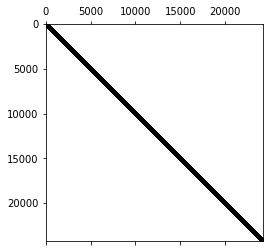

In [7]:
from scipy import sparse
A=sparse.coo_matrix(A)
assert A.shape == (d, d)
print('d = |V| = {}, k|V| < |E| = {}'.format(d, A.nnz))
plt.spy(A, markersize=2, color='black');

To be able to pool graph signals, we need first to coarsen the graph, i.e. to find which vertices to group together. At the end we'll have multiple graphs, like a pyramid, each at one level of resolution. The finest graph is where the input data lies, the coarsest graph is where the data at the output of the graph convolutional layers lie. That data, of reduced spatial dimensionality, can then be fed to a fully connected layer.

The parameter here is the number of times to coarsen the graph. Each coarsening approximately reduces the size of the graph by a factor two. Thus if you want a pooling of size 4 in the first layer followed by a pooling of size 2 in the second, you'll need to coarsen $\log_2(4+2) = 3$ times.

After coarsening we rearrange the vertices (and add fake vertices) such that pooling a graph signal is analog to pooling a 1D signal. See the [paper] for details.

[paper]: https://arxiv.org/abs/1606.09375

In [8]:
graphs, perm = coarsening.coarsen(A, levels=4, self_connections=False)

X_train = coarsening.perm_data(X_train, perm)
X_val = coarsening.perm_data(X_val, perm)
X_test = coarsening.perm_data(X_test, perm)

Layer 0: M_0 = |V| = 28272 nodes (4016 added),|E| = 100371 edges
Layer 1: M_1 = |V| = 14136 nodes (1472 added),|E| = 64474 edges
Layer 2: M_2 = |V| = 7068 nodes (489 added),|E| = 35301 edges
Layer 3: M_3 = |V| = 3534 nodes (103 added),|E| = 18608 edges
Layer 4: M_4 = |V| = 1767 nodes (0 added),|E| = 9404 edges


We finally need to compute the graph Laplacian $L$ for each of our graphs (the original and the coarsened versions), defined by their adjacency matrices $A$. The sole parameter here is the type of Laplacian, e.g. the combinatorial Laplacian, the normalized Laplacian or the random walk Laplacian.

In [9]:
L = [graph.laplacian(A, normalized=True) for A in graphs]
#graph.plot_spectrum(L)

# 3 Graph ConvNet

Here we apply the graph convolutional neural network to signals lying on graphs. After designing the architecture and setting the hyper-parameters, the model takes as inputs the data matrix $X$, the target $y$ and a list of graph Laplacians $L$, one per coarsening level.

The data, architecture and hyper-parameters are absolutely *not engineered to showcase performance*. Its sole purpose is to illustrate usage and functionality.

In [10]:
params = dict()
params['dir_name']       = 'demo'
params['num_epochs']     = 20
params['batch_size']     = round(n/6)
params['eval_frequency'] = 6

# Building blocks.
params['filter']         = 'chebyshev5'
params['brelu']          = 'b1relu'
params['pool']           = 'mpool1'

# Number of classes.
C = y.max() + 1
assert C == np.unique(y).size

# Architecture.
params['F']              = [20, 20]  # Number of graph convolutional filters.
params['K']              = [10, 10]  # Polynomial orders.
params['p']              = [1, 2]    # Pooling sizes.
params['M']              = [128, 64, C]  # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 5e-4
params['dropout']        = 0.95
params['learning_rate']  = 1e-3
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['decay_steps']    = n / params['batch_size']

In [11]:
tf.reset_default_graph()
model = models.cgcnn(L, **params)
print(X_train.shape)
accuracy, loss, t_step = model.fit(X_train, y_train, X_val, y_val)

NN architecture
  input: M_0 = 28272
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 28272 * 20 / 1 = 565440
    weights: F_0 * F_1 * K_1 = 1 * 20 * 10 = 200
    biases: F_1 = 20
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 28272 * 20 / 2 = 282720
    weights: F_1 * F_2 * K_2 = 20 * 20 * 10 = 4000
    biases: F_2 = 20
  layer 3: fc1
    representation: M_3 = 128
    weights: M_2 * M_3 = 282720 * 128 = 36188160
    biases: M_3 = 128
  layer 4: fc2
    representation: M_4 = 64
    weights: M_3 * M_4 = 128 * 64 = 8192
    biases: M_4 = 64
  layer 5: logits (softmax)
    representation: M_5 = 2.0
    weights: M_4 * M_5 = 64 * 2.0 = 128.0
    biases: M_5 = 2.0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
(474, 28272)
step 6 / 120 (epoch 1.00 / 20):
  learning_rate = 1.00e-03, loss_av

C:\Users\fkalaganis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 50.00 (5 / 10), f1 (weighted): 33.33, loss: 5.56e+02
  time: 11s (wall 10s)
step 12 / 120 (epoch 2.00 / 20):
  learning_rate = 9.50e-04, loss_average = 5.13e+01
  validation accuracy: 50.00 (5 / 10), f1 (weighted): 33.33, loss: 5.66e+02
  time: 25s (wall 20s)
step 18 / 120 (epoch 3.00 / 20):
  learning_rate = 9.02e-04, loss_average = 6.03e+01
  validation accuracy: 70.00 (7 / 10), f1 (weighted): 67.03, loss: 5.56e+02
  time: 37s (wall 30s)
step 24 / 120 (epoch 4.00 / 20):
  learning_rate = 8.57e-04, loss_average = 6.50e+01
  validation accuracy: 70.00 (7 / 10), f1 (weighted): 67.03, loss: 5.57e+02
  time: 49s (wall 39s)
step 30 / 120 (epoch 5.00 / 20):
  learning_rate = 8.15e-04, loss_average = 6.74e+01
  validation accuracy: 60.00 (6 / 10), f1 (weighted): 52.38, loss: 5.61e+02
  time: 62s (wall 48s)
step 36 / 120 (epoch 6.00 / 20):
  learning_rate = 7.74e-04, loss_average = 6.87e+01
  validation accuracy: 70.00 (7 / 10), f1 (weighted): 67.03, loss: 5.61e+02
  ti

# 4 Evaluation

We often want to monitor:
1. The convergence, i.e. the training loss and the classification accuracy on the validation set.
2. The performance, i.e. the classification accuracy on the testing set (to be compared with the training set accuracy to spot overfitting).

The `model_perf` class in [utils.py](utils.py) can be used to compactly evaluate multiple models.

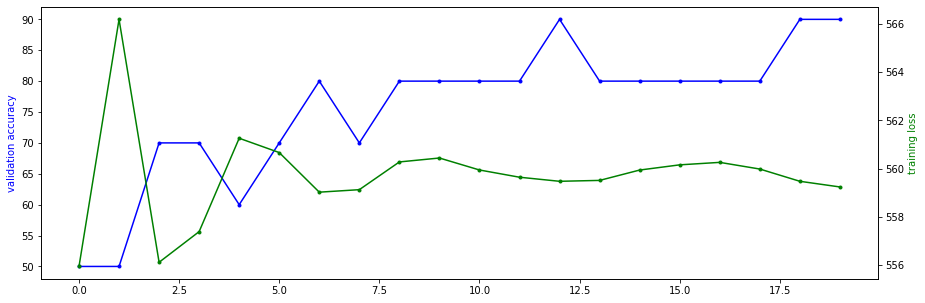

In [12]:
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(accuracy, 'b.-')
ax1.set_ylabel('validation accuracy', color='b')
ax2 = ax1.twinx()
ax2.plot(loss, 'g.-')
ax2.set_ylabel('training loss', color='g')
plt.show()

In [13]:
print('Time per step: {:.2f} ms'.format(t_step*1000))

Time per step: 1626.03 ms


Please keep in mind that some incosistencies may occur due to weight initialization and small validation/testing sets

In [14]:
res = model.evaluate(X_test, y_test)
print(res[0])

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from C:\Users\fkalaganis\Desktop\cnn_graph\lib\..\checkpoints\demo\model-120
accuracy: 80.00 (8 / 10), f1 (weighted): 80.00, loss: 5.60e+02
time: 3s (wall 1s)
